$$\textbf{Model Selection For Change-Point Detection}$$



**Objective**: The goal is to present (i) a model selection heuristics to find the number of change-points in a signal and (ii) wavelets for graph signals.



---

See Model Selection For Change-Point Detection Assignment first.


# Setup

In [1]:
%%capture
!pip install ruptures loadmydata contextily geopandas pygsp

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

from ruptures.metrics import hamming

import re
from math import asin, cos, radians, sin, sqrt

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.dates import DateFormatter
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform

import scipy.sparse as sparse

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

In [4]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

In [5]:
def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g

In [6]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

In [7]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [8]:
def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Question 2

In [9]:
# Mallows’ Cp

n_dims = 2

for n_bkps in [2, 4, 6, 8, 10]:
  for T in [100, 200, 500, 1000]:
    for sigma in [1.0, 2.0, 5.0, 7.0]:

        y, bkps = rpt.pw_constant(
            n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
        )

        sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
        C = 2*n_dims*(sigma_hat**2)

        algo = rpt.KernelCPD(kernel="linear").fit(y)
        predictedbkps = algo.predict(pen=C)

        print(f"For n_bkps={n_bkps}, T={T}, sigma={sigma:.2f}:")
        print(f"\t Estimated variance: {sigma_hat:.2f}.")
        print(f"\t True change points are: {bkps}")
        print(f"\t Detected change points are: {predictedbkps}")

        '''fig, ax_arr = rpt.display(y, bkps, predictedbkps)
        fig.show()'''

        print()

For n_bkps=2, T=100, sigma=1.00:
	 Estimated variance: 0.81.
	 True change points are: [33, 66, 100]
	 Detected change points are: [15, 23, 26, 28, 31, 33, 37, 39, 45, 47, 51, 54, 66, 92, 97, 100]

For n_bkps=2, T=100, sigma=2.00:
	 Estimated variance: 2.04.
	 True change points are: [32, 67, 100]
	 Detected change points are: [16, 26, 32, 35, 67, 73, 80, 100]

For n_bkps=2, T=100, sigma=5.00:
	 Estimated variance: 5.29.
	 True change points are: [35, 68, 100]
	 Detected change points are: [4, 7, 9, 11, 15, 21, 29, 31, 40, 44, 46, 53, 57, 68, 77, 80, 94, 100]

For n_bkps=2, T=100, sigma=7.00:
	 Estimated variance: 5.97.
	 True change points are: [33, 67, 100]
	 Detected change points are: [8, 10, 13, 15, 22, 24, 33, 36, 38, 40, 58, 60, 63, 67, 77, 83, 95, 100]

For n_bkps=2, T=200, sigma=1.00:
	 Estimated variance: 0.84.
	 True change points are: [68, 136, 200]
	 Detected change points are: [13, 15, 18, 26, 29, 32, 37, 39, 45, 49, 59, 63, 68, 76, 78, 81, 83, 88, 90, 92, 101, 113, 134, 

In [10]:
n_dims = 2
sigma = 2.0

N = {100:0, 200:0, 500:0, 1000:0}
CumHd = {100:.0, 200:.0, 500:.0, 1000:.0}

for n_bkps in [2, 4, 6, 8, 10]:
  for T in [100, 200, 500, 1000]:

      y, bkps = rpt.pw_constant(
          n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
      )

      sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
      C = 2*n_dims*(sigma_hat**2)

      algo = rpt.KernelCPD(kernel="linear").fit(y)
      predictedbkps = algo.predict(pen=C)

      N[T] += 1
      CumHd[T] += hamming(bkps, predictedbkps)

T = np.array(list(N.keys()))
Hd = np.array(list(CumHd.values()))/np.array(list(N.values()))

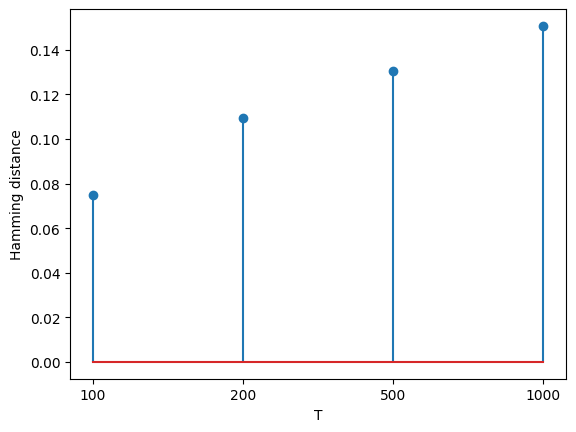

In [11]:
plt.stem(np.arange(len(T)), Hd)
plt.xticks(np.arange(len(T)), T)
plt.xlabel('T')
plt.ylabel('Hamming distance')
plt.savefig("simulation-mallows-T.png")
plt.show()

In [12]:
n_dims = 2
T = 500

N = {1.0:0, 2.0:0, 5.0:0, 7.0:0}
CumHd = {1.0:.0, 2.0:.0, 5.0:.0, 7.0:.0}

for n_bkps in [2, 4, 6, 8, 10]:
  for sigma in [1.0, 2.0, 5.0, 7.0]:

      y, bkps = rpt.pw_constant(
          n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
      )

      sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
      C = 2*n_dims*(sigma_hat**2)

      algo = rpt.KernelCPD(kernel="linear").fit(y)
      predictedbkps = algo.predict(pen=C)

      N[sigma] += 1
      CumHd[sigma] += hamming(bkps, predictedbkps)

sigma = np.array(list(N.keys()))
Hd = np.array(list(CumHd.values()))/np.array(list(N.values()))

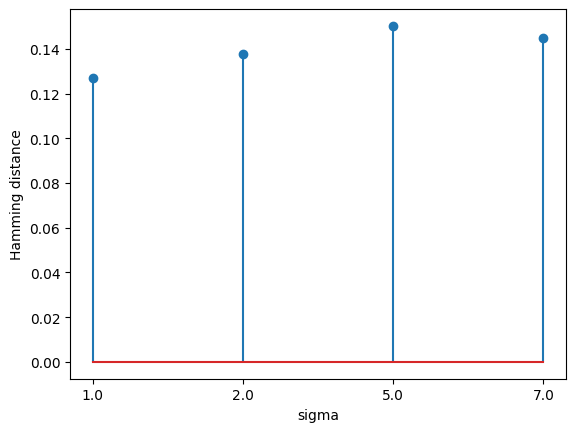

In [13]:
plt.stem(np.arange(len(sigma)), Hd)
plt.xticks(np.arange(len(sigma)), sigma)
plt.xlabel('sigma')
plt.ylabel('Hamming distance')
plt.savefig("simulation-mallows-sigma.png")
plt.show()

# Question 3

In [14]:
# Slope heuristics:

n_dims = 2

for n_bkps in [2, 4, 6, 8, 10]:
  for T in [100, 200, 500, 1000]:
    for sigma in [1.0, 2.0, 5.0, 7.0]:

        y, bkps = rpt.pw_constant(
            n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
        )

        sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
        C = 2*n_dims*(sigma_hat**2)

        f = []

        for K in np.arange(15, int(0.4*T))[-10:]:

          predictedbkps = rpt.KernelCPD(kernel="linear").fit_predict(y, n_bkps=K)
          cost = rpt.costs.CostL2().fit(y)
          f.append(cost.sum_of_costs(predictedbkps))

        C_slope = -T*np.array(np.poly1d(np.polyfit(f, np.arange(15, int(0.4*T))[-10:], 1)))[0]


        algo = rpt.KernelCPD(kernel="linear").fit(y)
        predictedbkps = algo.predict(pen=C_slope*n_dims)


        print(f"For n_bkps={n_bkps}, T={T}, sigma={sigma:.2f}:")
        print(f"\t Slope heuristic value: {C_slope:.2f}.")
        print(f"\t True change points are: {bkps}")
        print(f"\t Detected change points are: {predictedbkps}")

        '''fig, ax_arr = rpt.display(y, bkps, predictedbkps)
        fig.show()'''

        print()

For n_bkps=2, T=100, sigma=1.00:
	 Slope heuristic value: 86.69.
	 True change points are: [34, 66, 100]
	 Detected change points are: [34, 66, 100]

For n_bkps=2, T=100, sigma=2.00:
	 Slope heuristic value: 33.43.
	 True change points are: [34, 69, 100]
	 Detected change points are: [34, 69, 100]

For n_bkps=2, T=100, sigma=5.00:
	 Slope heuristic value: 4.29.
	 True change points are: [33, 66, 100]
	 Detected change points are: [2, 5, 7, 9, 11, 13, 16, 19, 21, 23, 25, 27, 30, 33, 35, 37, 39, 41, 44, 46, 49, 52, 54, 56, 58, 60, 62, 65, 67, 69, 71, 74, 77, 79, 82, 84, 86, 88, 91, 93, 95, 98, 100]

For n_bkps=2, T=100, sigma=7.00:
	 Slope heuristic value: 1.84.
	 True change points are: [34, 66, 100]
	 Detected change points are: [3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 24, 26, 28, 30, 32, 35, 37, 40, 42, 44, 47, 49, 51, 53, 55, 57, 59, 61, 63, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 91, 93, 95, 98, 100]

For n_bkps=2, T=200, sigma=1.00:
	 Slope heuristic value: 282.25.
	 True chang

In [15]:
n_dims = 2
sigma = 2.0

N = {100:0, 200:0, 500:0, 1000:0}
CumHd = {100:.0, 200:.0, 500:.0, 1000:.0}

for n_bkps in [2, 4, 6, 8, 10]:
  for T in [100, 200, 500, 1000]:

      y, bkps = rpt.pw_constant(
          n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
      )

      sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
      C = 2*n_dims*(sigma_hat**2)

      f = []

      for K in np.arange(15, int(0.4*T))[-10:]:

        predictedbkps = rpt.KernelCPD(kernel="linear").fit_predict(y, n_bkps=K)
        cost = rpt.costs.CostL2().fit(y)
        f.append(cost.sum_of_costs(predictedbkps))

      C_slope = -T*np.array(np.poly1d(np.polyfit(f, np.arange(15, int(0.4*T))[-10:], 1)))[0]


      algo = rpt.KernelCPD(kernel="linear").fit(y)
      predictedbkps = algo.predict(pen=C_slope*n_dims)

      N[T] += 1
      CumHd[T] += hamming(bkps, predictedbkps)

T = np.array(list(N.keys()))
Hd = np.array(list(CumHd.values()))/np.array(list(N.values()))

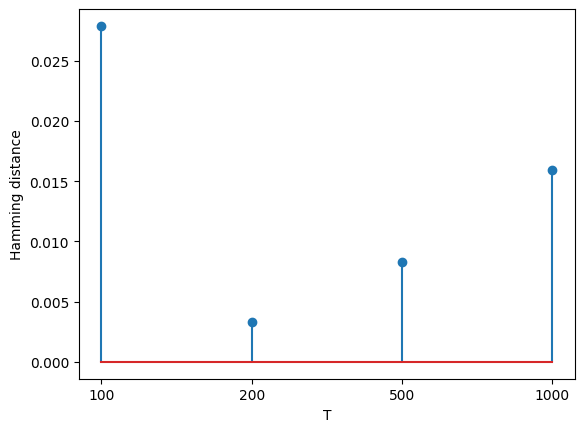

In [16]:
plt.stem(np.arange(len(T)), Hd)
plt.xticks(np.arange(len(T)), T)
plt.xlabel('T')
plt.ylabel('Hamming distance')
plt.savefig("simulation-slope-T.png")
plt.show()

In [17]:
n_dims = 2
T = 500

N = {1.0:0, 2.0:0, 5.0:0, 7.0:0}
CumHd = {1.0:.0, 2.0:.0, 5.0:.0, 7.0:.0}

for n_bkps in [2, 4, 6, 8, 10]:
  for sigma in [1.0, 2.0, 5.0, 7.0]:

      y, bkps = rpt.pw_constant(
          n_samples=T, n_features=n_dims, n_bkps=n_bkps, noise_std=sigma
      )

      sigma_hat = np.sqrt((y[:T//10, :].std(axis=0)**2).sum()/n_dims)
      C = 2*n_dims*(sigma_hat**2)

      f = []

      for K in np.arange(15, int(0.4*T))[-10:]:

        predictedbkps = rpt.KernelCPD(kernel="linear").fit_predict(y, n_bkps=K)
        cost = rpt.costs.CostL2().fit(y)
        f.append(cost.sum_of_costs(predictedbkps))

      C_slope = -T*np.array(np.poly1d(np.polyfit(f, np.arange(15, int(0.4*T))[-10:], 1)))[0]

      algo = rpt.KernelCPD(kernel="linear").fit(y)
      predictedbkps = algo.predict(pen=C_slope*n_dims)

      N[sigma] += 1
      CumHd[sigma] += hamming(bkps, predictedbkps)

sigma = np.array(list(N.keys()))
Hd = np.array(list(CumHd.values()))/np.array(list(N.values()))

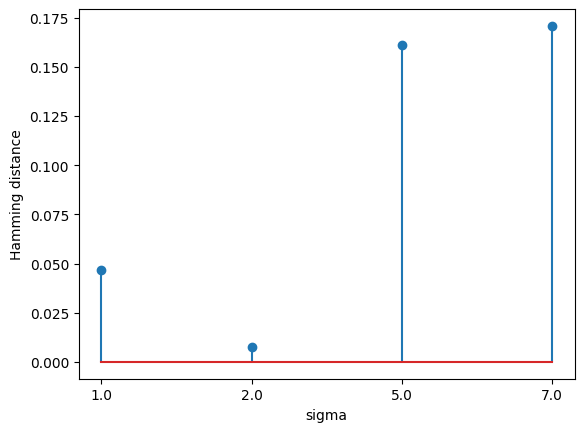

In [18]:
plt.stem(np.arange(len(sigma)), Hd)
plt.xticks(np.arange(len(sigma)), sigma)
plt.xlabel('sigma')
plt.ylabel('Hamming distance')
plt.savefig("simulation-slope-sigma.png")
plt.show()

# Question 4

In [19]:
def g_u_hat(x, R):
    lambda_n=12
    M=9
    a=12/(10-R)
    if x<0 and x>=-R*a:
      return 0.5*(1+ np.cos(2*np.pi*(0.5+ x/(a*R))))
    else:
      return 0

def g_m_hat(x ,m, R):
  if 0<=x<=12:
    return g_u_hat(x-a*m, R)
  else:
    return 0

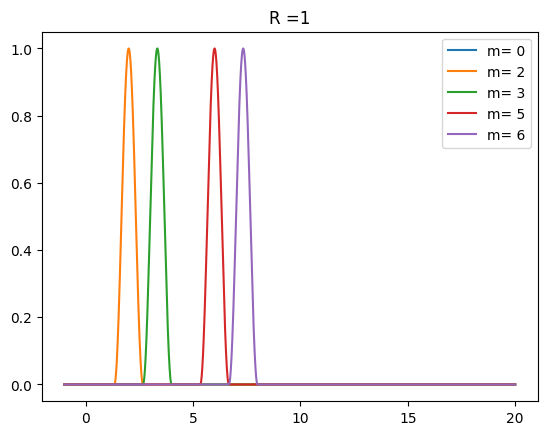

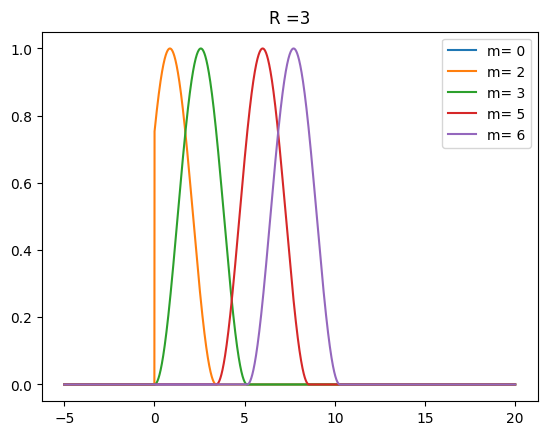

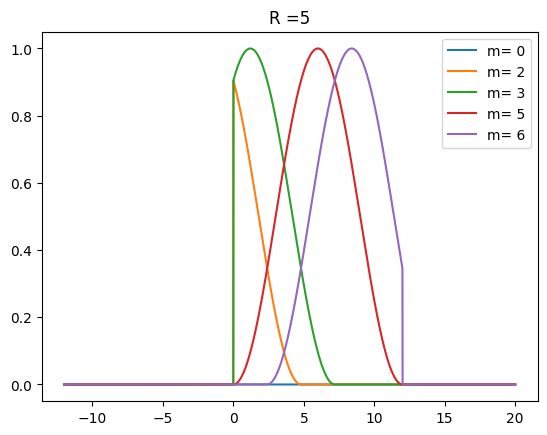

In [20]:
RR=[1,3,5]
for R in RR:
  a=12/(10-R)
  x=np.linspace(-int(R*a) , 20, num=5000, endpoint=True, retstep=False, dtype=None, axis=0)
  y=[]
  m=[0,2,3,5,6]
  for k in range(len(m)):
    y.append(np.array([g_m_hat(i, m[k],  R) for i in x]))

  for k in range(len(m)):
    plt.plot(x,y[k], label =f"m= {m[k]}")
  plt.legend()
  plt.title(f"R ={R}")
  plt.show()

# Question 5

### Data loading:

In [21]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

100%|██████████| 1.14M/1.14M [00:01<00:00, 691kiB/s]
100%|██████████| 5.06k/5.06k [00:00<00:00, 1.15MiB/s]


The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [22]:
CRS = "EPSG:4326"
# convert temperature from Kelvin to Celsius:

data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df:

stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [24]:
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


### Removing stations with missing values in temperature:

In [25]:
dic= dict(temperature_df.apply(lambda x: sum(x.isnull()))) # Checking stations with missing values

missing=[]
for i in range(len(dic)):
  if dic[list(dic.keys())[i]] !=0:
    missing.append(list(dic.keys())[i])
print(len(missing),"Stations with missing values :", missing)

18 Stations with missing values : ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [26]:
temperature_df = temperature_df.drop(columns=missing) # Dropping stations with missing values
temperature_df = temperature_df.sort_index(axis=1)    # Sorting by station name

In [27]:
temperature_df.head()

station_name,AURAY,BELLE ILE-LE TALUT,BIGNAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,ILE-DE-BREHAT,KERPERT,LORIENT-LANN BIHOUE,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.3,11.3,7.1,6.8,10.4,8.3,9.0,7.0,5.9,9.0,...,6.1,9.3,9.8,7.4,8.3,7.5,9.0,9.3,10.8,9.7
2014-01-01 01:00:00,10.4,10.3,7.6,6.5,10.6,7.8,10.0,7.0,5.9,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,10.0,11.2,7.7,6.5,10.2,8.4,9.5,7.8,6.4,8.9,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,10.4,11.4,7.9,7.1,10.6,8.4,10.4,8.3,6.7,10.1,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,10.8,11.4,8.8,7.6,10.6,8.9,10.8,8.9,6.9,10.4,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2


In [29]:
drop_cond = stations_df.Nom.isin(missing)
stations_df = stations_df[-drop_cond]            # Dropping stations with missing values
stations_df = stations_df.sort_values(by="Nom")  # Sorting by station name

In [30]:
stations_df.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude
40,56007001,AURAY,47.659167,-2.971000,201560,2308970,26
41,56009001,BELLE ILE-LE TALUT,47.294333,-3.218333,180161,2269794,34
42,56017003,BIGNAN,47.884333,-2.728833,221324,2332754,112
34,35228001,DINARD,48.589000,-2.075833,274478,2408058,58
35,44069002,GUERANDE,47.292333,-2.430167,239631,2265660,4


In [31]:
drop_cond = stations_gdf.Nom.isin(missing)
stations_gdf = stations_gdf[-drop_cond] # Dropping stations with missing values
stations_gdf = stations_gdf.sort_values(by="Nom") # Sorting by station name

In [32]:
stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
40,56007001,AURAY,47.659167,-2.971000,201560,2308970,26,POINT (-2.97100 47.65917)
41,56009001,BELLE ILE-LE TALUT,47.294333,-3.218333,180161,2269794,34,POINT (-3.21833 47.29433)
42,56017003,BIGNAN,47.884333,-2.728833,221324,2332754,112,POINT (-2.72883 47.88433)
34,35228001,DINARD,48.589000,-2.075833,274478,2408058,58,POINT (-2.07583 48.58900)
35,44069002,GUERANDE,47.292333,-2.430167,239631,2265660,4,POINT (-2.43017 47.29233)


### Stations localization visualization:

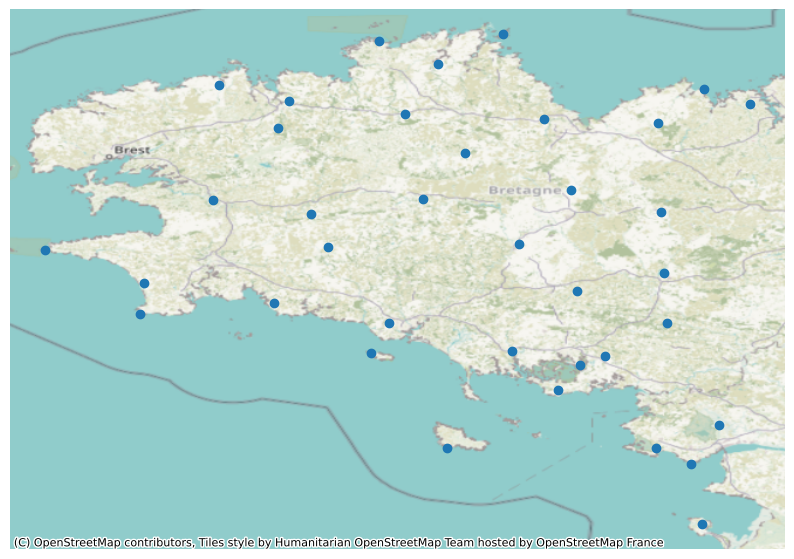

In [38]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

### Graph construction:

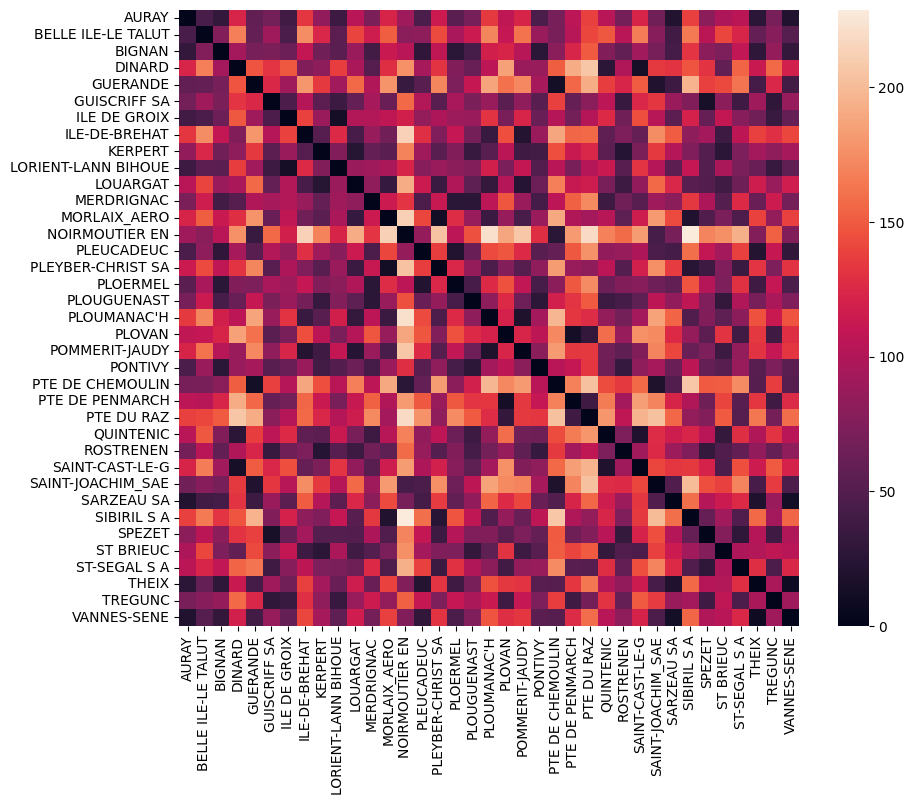

In [39]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

In [41]:
# Graph construction using the distance matrix and exponential smoothing:

sigma = np.median(dist_mat_condensed)             # median heuristic

threshold = 0.83                                  # The minimum threshold at which the graph is connected with an average degree of at least 3.
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

### Signals smoothness computation:

In [42]:
# Laplacian matrix:

L = G_gaussian.L.todense()

In [43]:
# Signals matrix:

f = temperature_df.to_numpy()

In [44]:
# Signals smoothness array:

S = np.diag(f@L@f.T)

In [46]:
print(f"The signal is the least smooth at: {temperature_df.index[S.argmax()]}, with a smoothness value which is equal to: {S.max():.2f}\n")
print(f"The signal is the smoothest at: {temperature_df.index[S.argmin()]}, with a smoothness value which is equal to: {S.min():.2f}")

The signal is the least smooth at: 2014-01-21 03:00:00, with a smoothness value which is equal to: 583.85

The signal is the smoothest at: 2014-01-24 23:00:00, with a smoothness value which is equal to: 20.67


# Question 6

In [47]:
color_map = {0:'green',1:'blue',2:'red'}

In [48]:
lbda, U = eigh(L)

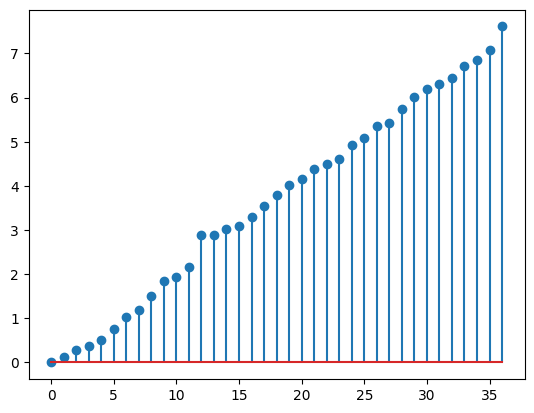

In [49]:
plt.stem(np.arange(len(lbda)), lbda)
plt.show()

In [50]:
M = 9
R = 3
a = lbda[-1]/(M+1-R)

g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)

# Coding the matrix W_f(m, .)
def W(f, m):
  g_lbda = np.apply_along_axis(lambda x: g_u_hat(x-a*m), 0, lbda[None,:]).squeeze()
  return f.T@(U@np.diag(g_lbda)@(U.T))

In [51]:
# Tested signals:

# Least smooth
least_smooth = temperature_df.iloc[S.argmax()].to_numpy()
# Smoothest
most_smooth = temperature_df.iloc[S.argmin()].to_numpy()
# First one:
first_av = temperature_df.iloc[0].to_numpy()

### Least smooth:

In [52]:
signal = least_smooth

low_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(1, 4)])
medium_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(4, 7)])
high_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(7, M+1)])

# Nodes classification:
clf = np.concatenate([low_freq_energy, medium_freq_energy, high_freq_energy], axis=0).argmax(axis=0)

<ipython-input-50-d034d76a47de>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)


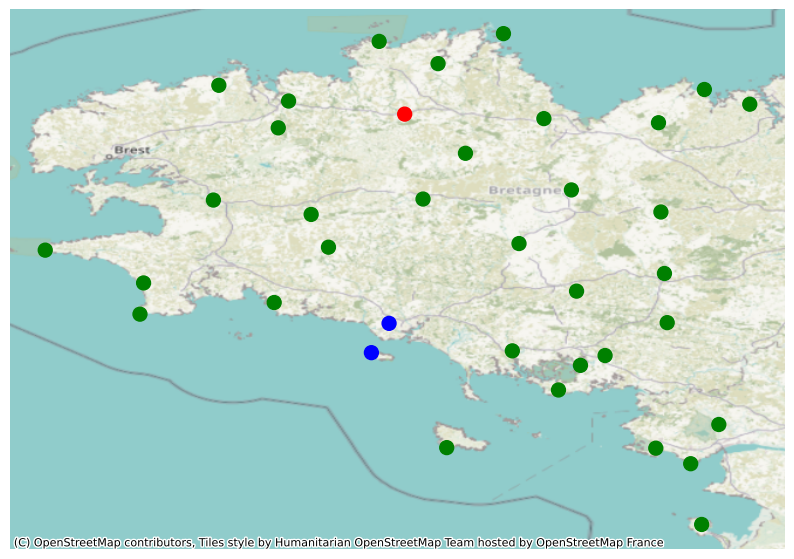

In [53]:
ax = stations_gdf.geometry.plot(figsize=(10, 10),color=list(map(lambda i: color_map[i], clf)), markersize=100)
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
plt.savefig('Least smooth.png')

### Most smooth:

In [54]:
signal = most_smooth

low_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(1, 4)])
medium_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(4, 7)])
high_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(7, M+1)])

# Nodes classification:
clf = np.concatenate([low_freq_energy, medium_freq_energy, high_freq_energy], axis=0).argmax(axis=0)
clf

<ipython-input-50-d034d76a47de>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

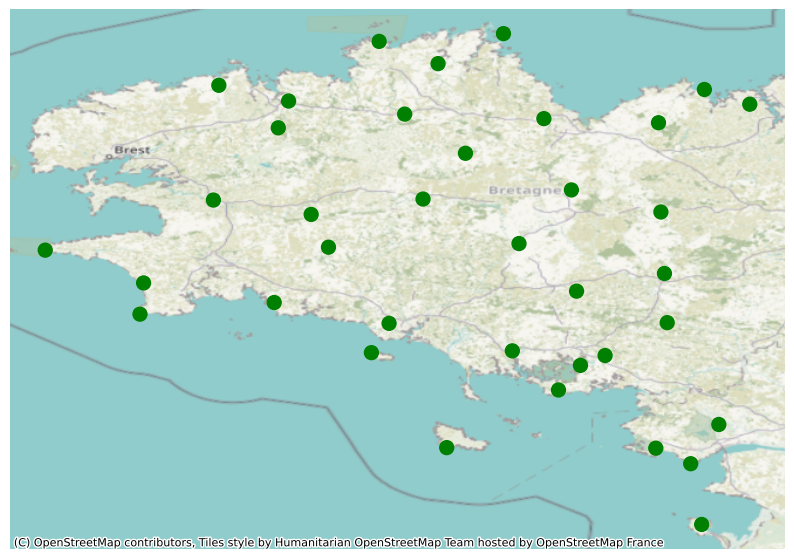

In [55]:
ax = stations_gdf.geometry.plot(figsize=(10, 10),color=list(map(lambda i: color_map[i], clf)), markersize=100)
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
plt.savefig('Most smooth.png')

### First available:

In [56]:
signal = first_av

low_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(1, 4)])
medium_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(4, 7)])
high_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(7, M+1)])

# Nodes classification:
clf = np.concatenate([low_freq_energy, medium_freq_energy, high_freq_energy], axis=0).argmax(axis=0)
clf

<ipython-input-50-d034d76a47de>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

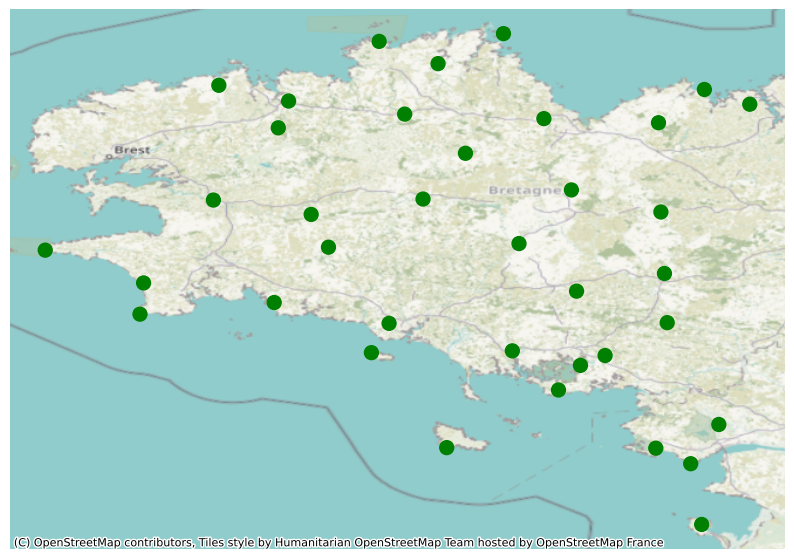

In [57]:
ax = stations_gdf.geometry.plot(figsize=(10, 10),color=list(map(lambda i: color_map[i], clf)), markersize=100)
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
plt.savefig('First available.png')

# Question 7

<ipython-input-50-d034d76a47de>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)


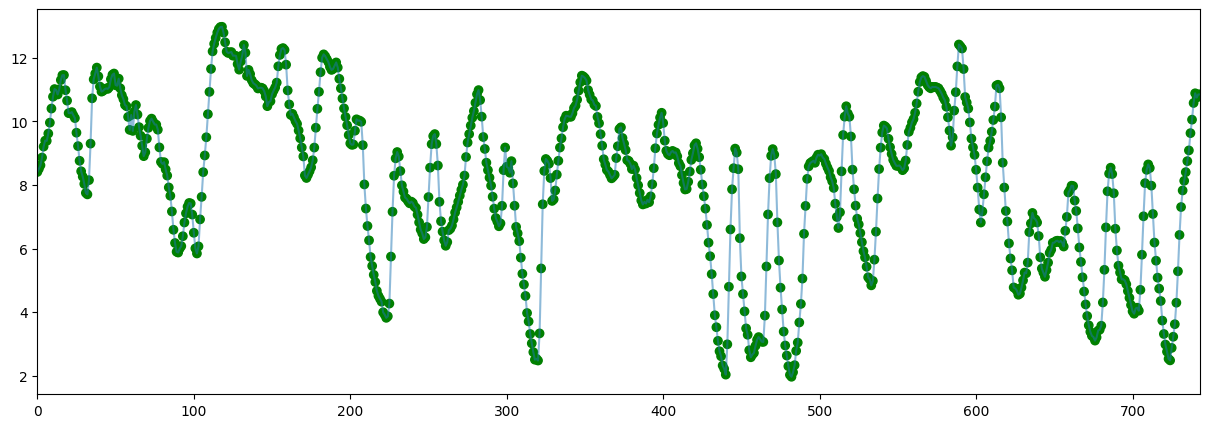

In [58]:
T = len(temperature_df)

y = np.zeros(T)
x = np.arange(T)
class_array = np.zeros(T, dtype=np.int64)

for i in range(T):

  signal = temperature_df.iloc[i].to_numpy()
  y[i] = signal.mean()

  low_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(1, 4)])
  medium_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(4, 7)])
  high_freq_energy = sum([W(signal, m)[None,:]**2 for m in range(7, M+1)])

  clf = np.concatenate([low_freq_energy, medium_freq_energy, high_freq_energy], axis=0).argmax(axis=0)
  cl = np.take_along_axis(np.eye(3), clf[:,None], 0).sum(axis=0).argmax()
  class_array[i] = cl

colors = ["green", "blue", "red"]
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
plt.savefig('avg_temp.png')

# Question 8

In [59]:
f = temperature_df.to_numpy()
T, n = f.shape

In [60]:
A_t = np.zeros((T, T))
for t_1 in range(T):
  for t_2 in range(t_1+1, T):
    if np.abs(t_1 - t_2) == 1:
      A_t[t_1, t_2] = A_t[t_2, t_1] = 1

L_t = np.diag(A_t@np.ones((T, 1)).squeeze()) - A_t

In [61]:
L_v = G_gaussian.L.todense()

In [62]:
# L_h = sparse.kron(sparse.identity(T), L_v) + sparse.kron(L_t, sparse.identity(n))

In [63]:
lbda_t, U_t = eigh(L_t)
lbda_v, U_v = eigh(L_v)

In [64]:
lbda_h = (lbda_t[:,None]+lbda_v[None,:])

In [65]:
M = 9
R = 3
a = lbda_h[-1, -1]/(M+1-R)

g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)

def W_h(f, m):
  g_lbda = np.apply_along_axis(lambda x: g_u_hat(x-a*m), 0, lbda_h[None,:]).squeeze()
  res = 0
  for t in range(T):
    for v in range(n):
      u_th = (U_t[:,t][None,:]*U_v[:,v][:,None]).flatten()
      res += (g_u_hat(lbda_h[t,v]-a*m)*(f*u_th).sum())*u_th
  return res

In [66]:
signal = f.flatten()

low_freq_energy = sum([W_h(signal, m)[None,:]**2 for m in range(1, 4)])
medium_freq_energy = sum([W_h(signal, m)[None,:]**2 for m in range(4, 7)])
high_freq_energy = sum([W_h(signal, m)[None,:]**2 for m in range(7, M+1)])

# Nodes classification:
clf = np.concatenate([low_freq_energy, medium_freq_energy, high_freq_energy], axis=0).argmax(axis=0)

<ipython-input-65-90dd750925cd>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g_u_hat = lambda x: 0.5*(1.0 + np.cos(2*np.pi*(0.5+ x/(a*R))))*float(-R*a<=x<0)


In [67]:
clf = clf.reshape(n, T)

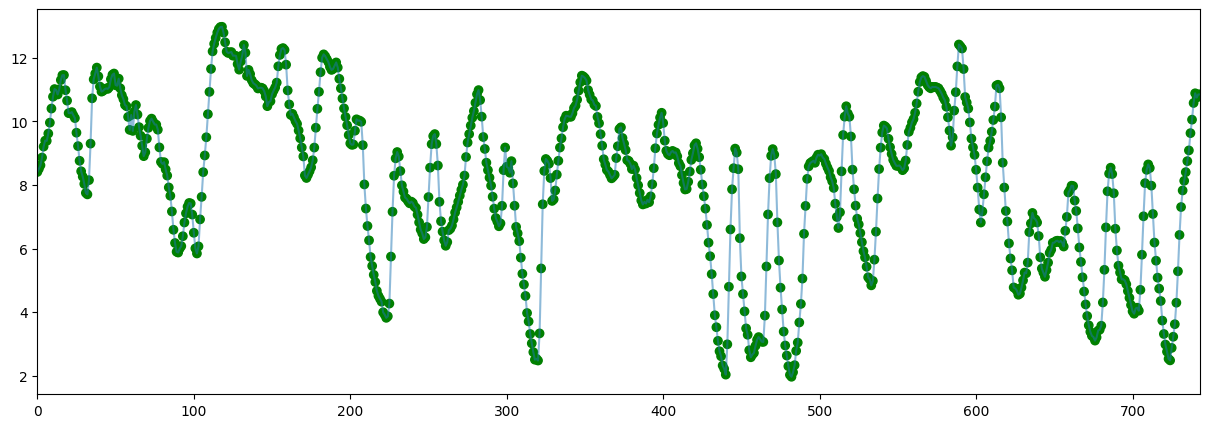

In [68]:
for i in range(T):

  cl = np.take_along_axis(np.eye(3), clf[:,i][:,None], 0).sum(axis=0).argmax()
  class_array[i] = cl

colors = ["green", "blue", "red"]
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)
plt.savefig('avg_temp_temporal.png')